# DAY 1

# Now creating a new script for first computing density from the dataset, then creating a grid with the same x-distance, then computing windstress and aligning with the ferrybox data by interpolating windstress data to the ferrybox.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from pathlib import Path
import cmocean as cmo
import numpy as np
import gsw
from pathlib import Path
from pyproj import Geod
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d



In [2]:
# Function to load ONE file
def load_files(filepath: str | Path) -> pd.DataFrame:
    """
    Read an SBE text export that has metadata lines before the real header.
    Returns a tidy DataFrame with an extra 'datetime' column.
    """
    filepath = Path(filepath)

    # detect how many metadata lines to skip ------------------
    with filepath.open('r', encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Date") and "Time" in line:
                skiprows = i
                break

    # read the rest ------------------------------------------
    df = pd.read_csv(
        filepath,
        sep=r'\s+',                 # whitespace delimiter
        skiprows=skiprows,          # jump over metadata
        encoding='latin1'
    )

    # combine date/time to real datetime ----------------------
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['source']   = filepath.stem   # keep the filename → handy for legends
    df = df.iloc[1:]                # drop the first data row
    return df


# 2.  Load desired files

files = [
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\224_2025-05-06_07.35.09__to_Skagen_741601.txt", #Dag 1 
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-07_07.11.44_Skagen_to__741601.txt", # Halva dag 2
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\225_2025-05-07_07.11.44_Skagen_to_Skagen_741601.txt", # Hela dag 2
    #r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-08_07.24.29_Skagen_to__741601.txt" #Dag 3
]
dfs = [load_files(f) for f in files]

# Concatenate if you just want one big table:
df_all = pd.concat(dfs, ignore_index=True)

In [3]:
df_all

,Date,Time,Latitude,Longitude,Course,Speed,Temp_SBE45,Cond_SBE45,Salinity_SBE45,SoundVel_SBE45,...,pH,Chlorophyll,Turbidity,pressure,flow_main,flow_SBE45,Phycocyanin,CDOM,datetime,source
0,2025.05.06,07:37:00,57.667360,11.782509,227.331050,11.000000,10.153903,2.439251,21.301802,1473.792397,...,9.061328,0.958452,1.984402,206.345250,8.967182,3.310180,1.031333,-0.015625,2025-05-06 07:37:00,224_2025-05-06_07.35.09__to_Skagen_741601
1,2025.05.06,07:38:00,57.665152,11.778037,226.105023,11.000000,10.168917,2.505584,21.929166,1474.605690,...,9.062532,0.852692,1.977557,206.427254,8.943592,3.302311,1.012083,-0.017500,2025-05-06 07:38:00,224_2025-05-06_07.35.09__to_Skagen_741601
2,2025.05.06,07:39:00,57.662873,11.773772,223.215103,11.000000,10.182814,2.569033,22.530538,1475.383397,...,9.064200,0.811377,1.896585,206.325303,8.978257,3.304303,0.981750,-0.018750,2025-05-06 07:39:00,224_2025-05-06_07.35.09__to_Skagen_741601
3,2025.05.06,07:40:00,57.660707,11.769391,234.350000,11.000000,10.144962,2.512420,22.009384,1474.613534,...,9.062676,0.790275,1.895693,199.694033,8.977371,3.320903,1.022583,-0.014375,2025-05-06 07:40:00,224_2025-05-06_07.35.09__to_Skagen_741601
4,2025.05.06,07:41:00,57.659370,11.764079,249.522831,11.000000,10.074745,2.594584,22.844819,1475.362052,...,9.063355,0.896750,1.961646,203.430771,8.952452,3.320804,1.133417,-0.017708,2025-05-06 07:41:00,224_2025-05-06_07.35.09__to_Skagen_741601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2025.05.06,15:20:00,57.709857,10.629703,303.970660,10.000000,10.769966,3.415120,30.350514,1486.951552,...,9.048560,0.630843,1.299025,194.917835,8.548326,3.202412,0.810576,-0.017394,2025-05-06 15:20:00,224_2025-05-06_07.35.09__to_Skagen_741601
464,2025.05.06,15:21:00,57.711511,10.625163,303.242280,10.000000,10.678016,3.410235,30.378640,1486.657190,...,9.048598,0.656364,1.296098,196.083626,8.543785,3.205035,0.823667,-0.014375,2025-05-06 15:21:00,224_2025-05-06_07.35.09__to_Skagen_741601
465,2025.05.06,15:22:00,57.712860,10.620621,292.098592,9.126761,10.516971,3.398860,30.400131,1486.105948,...,9.048800,0.626972,1.302539,198.171412,8.545778,3.201682,0.795667,-0.018750,2025-05-06 15:22:00,224_2025-05-06_07.35.09__to_Skagen_741601
466,2025.05.06,15:23:00,57.713594,10.615796,281.241218,9.000000,10.437086,3.388974,30.368640,1485.780845,...,9.049068,0.578992,1.337657,196.677604,8.553309,3.208853,0.810833,-0.017083,2025-05-06 15:23:00,224_2025-05-06_07.35.09__to_Skagen_741601


In [4]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Ensure datetime format
# df_all['datetime'] = pd.to_datetime(df_all['datetime'])

# # Set datetime as index
# df_all.set_index('datetime', inplace=True)

# # Get datetime range for title
# start_time = df_all.index.min().strftime('%Y-%m-%d %H:%M')
# end_time = df_all.index.max().strftime('%Y-%m-%d %H:%M')
# time_range_title = f'Data from {start_time} to {end_time}'

# # Create subplots
# fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# # Plot Temp_SBE45
# axes[0].plot(df_all.index, df_all['Temp_in_SBE38'], color='tab:blue')
# axes[0].set_title(f'Temp_in_SBE38 ({time_range_title})')
# axes[0].set_ylabel('°C')
# axes[0].grid(True)

# # Plot Salinity_SBE45
# axes[1].plot(df_all.index, df_all['Salinity_SBE45'], color='tab:green')
# axes[1].set_title(f'Salinity_SBE45 ({time_range_title})')
# axes[1].set_ylabel('PSU')
# axes[1].set_xlabel('Timestamp')
# axes[1].grid(True)

# plt.tight_layout()
# plt.show()


Remove/Interpolate the outlier in the transect from skagen to gbg, last day

In [5]:
# New way thats working
# There is one outlier in the temp data, I will flag it and then interpolate inbetween

# # flag outliers
# bad = df_all['Temp_in_SBE38'] > 100            # any value > 100 °C is impossible  
# df_all.loc[bad, 'Temp_in_SBE38'] = np.nan      # set those outliers to NaN

df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].mask(df_all['Temp_in_SBE38'] > 100)

# interpolate the gaps
df_all = df_all.set_index('datetime')              # make time the index  
df_all['Temp_in_SBE38'] = df_all['Temp_in_SBE38'].interpolate('time')  # linear fill in time  
df_all = df_all.reset_index()                      # restore datetime as a column

Get the sigma density and Cons. temp and abs. sal

In [6]:
# Convert everything to TEOS-10
SP  = df_all['Salinity_SBE45'].to_numpy()   # practical salinity is what we have in the dataset, will convert to Absolute sal
T   = df_all['Temp_in_SBE38'].to_numpy()    # in-situ temp (°C, ITS-90), will convert to Conservative T
p   = df_all['pressure'].to_numpy() / 100.0    # mbar → dbar  (1 dbar = 100 mbar)
lon = df_all['Longitude'].to_numpy()
lat = df_all['Latitude'].to_numpy()

SA = gsw.SA_from_SP(SP, p, lon, lat)    # absolute salinity
CT = gsw.CT_from_t(SA, T, p)            # conservative temp

# Store everything in the the dataset
df_all['SA'] = SA
df_all['CT'] = CT
df_all['press_db'] =p
df_all['sigma0'] = gsw.sigma0(SA, CT)       # potential density anomaly σθ

Compute boyancy and Boyancy gradient

In [7]:
# Constants
g = 9.81                    # Gravity (m/s²)
target_depth = 2.0          # Target depth for buoyancy analysis (m)
depth_window = 0.5          # Allowed variation around target depth (± m)
dx = 200                 # Regular horizontal resolution (m)
geod = Geod(ellps="WGS84")  # Geodesic calculator

# Step 1: Convert pressure to depth and filter around 2 m
df_all['Depth'] = -gsw.z_from_p(df_all['pressure'] / 100, df_all['Latitude'])
depth = df_all["Depth"].to_numpy()
mask = np.abs(depth - target_depth) <= depth_window
df_near_depth = df_all[mask].copy()

# Step 2: Compute buoyancy from potential density anomaly
lon = df_near_depth["Longitude"].to_numpy()
lat = df_near_depth["Latitude"].to_numpy()
sigma0 = df_near_depth["sigma0"].to_numpy()
rho = sigma0 + 1000.0
rho0 = np.nanmean(rho)
b = g * (1 - (rho / rho0))  # Buoyancy in m/s²

# Step 3: Compute cumulative distance along the ship track
_, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
dist = np.concatenate(([0.0], np.cumsum(step)))

# Step 4: Interpolate buoyancy onto regular spatial grid
d_reg = np.arange(0, dist[-1], dx)
b_reg = interp1d(dist, b, bounds_error=False, fill_value=np.nan)(d_reg)
b_reg_smooth = gaussian_filter1d(b_reg, sigma=2)  # or use uniform_filter1d  sigma=2 on 1000 m grid ≈ 2 km smoothing scale — reasonable for mesoscale signals.


# Step 5: Compute horizontal buoyancy gradient ∂b/∂x
#dbdx_reg = np.gradient(b_reg, dx)
dbdx_reg = np.gradient(b_reg_smooth, dx)


# Step 6: Interpolate gradient back to original (irregular) positions
buoy_grad = np.interp(dist, d_reg, dbdx_reg, left=np.nan, right=np.nan)

# Step 7: Store in cleaned dataframe
df_clean = df_near_depth.copy()
df_clean["buoy_grad"] = buoy_grad

# Summary output
print("\n--- BUOYANCY ANALYSIS SUMMARY ---")
print(f"Target depth: {target_depth} m ± {depth_window} m")
print(f"Data points total: {len(depth)}")
print(f"Points near target depth: {np.sum(mask)}")

print("\n--- DEPTH RANGE ---")
print(f"Min depth: {np.nanmin(depth):.3f} m")
print(f"Max depth: {np.nanmax(depth):.3f} m")

print("\n--- DENSITY ---")
print(f"rho0 (mean): {rho0:.3f} kg/m³")
print(f"rho range: {np.nanmin(rho):.3f} – {np.nanmax(rho):.3f} kg/m³")
print(f"buoyancy (b) range: {np.nanmin(b):.2e} – {np.nanmax(b):.2e} m/s²")

print("\n--- DISTANCE ALONG TRACK ---")
print(f"Step sizes (m): min {np.min(step):.1f}, max {np.max(step):.1f}")
print(f"Total distance: {dist[-1]:.1f} m")

print("\n--- INTERPOLATED BUOYANCY ---")
print(f"b_reg range: {np.nanmin(b_reg):.2e} – {np.nanmax(b_reg):.2e} m/s²")
print(f"Interpolated grid points: {len(b_reg)}")

print("\n--- BUOYANCY GRADIENT (∂b/∂x) ---")
print(f"Gradient range: {np.nanmin(dbdx_reg):.2e} – {np.nanmax(dbdx_reg):.2e} s⁻²")

print("\n--- FINAL GRADIENT ON ORIGINAL POINTS ---")
print(f"Range: {np.nanmin(buoy_grad):.2e} – {np.nanmax(buoy_grad):.2e} s⁻²")
print(f"Non-NaN values: {np.sum(~np.isnan(buoy_grad))} / {len(buoy_grad)}")



--- BUOYANCY ANALYSIS SUMMARY ---
Target depth: 2.0 m ± 0.5 m
Data points total: 468
Points near target depth: 468

--- DEPTH RANGE ---
Min depth: 1.878 m
Max depth: 2.209 m

--- DENSITY ---
rho0 (mean): 1019.401 kg/m³
rho range: 1015.961 – 1023.330 kg/m³
buoyancy (b) range: -3.78e-02 – 3.31e-02 m/s²

--- DISTANCE ALONG TRACK ---
Step sizes (m): min 0.1, max 381.5
Total distance: 127272.1 m

--- INTERPOLATED BUOYANCY ---
b_reg range: -3.78e-02 – 3.08e-02 m/s²
Interpolated grid points: 637

--- BUOYANCY GRADIENT (∂b/∂x) ---
Gradient range: -2.24e-05 – 1.19e-05 s⁻²

--- FINAL GRADIENT ON ORIGINAL POINTS ---
Range: -2.13e-05 – 1.17e-05 s⁻²
Non-NaN values: 467 / 468


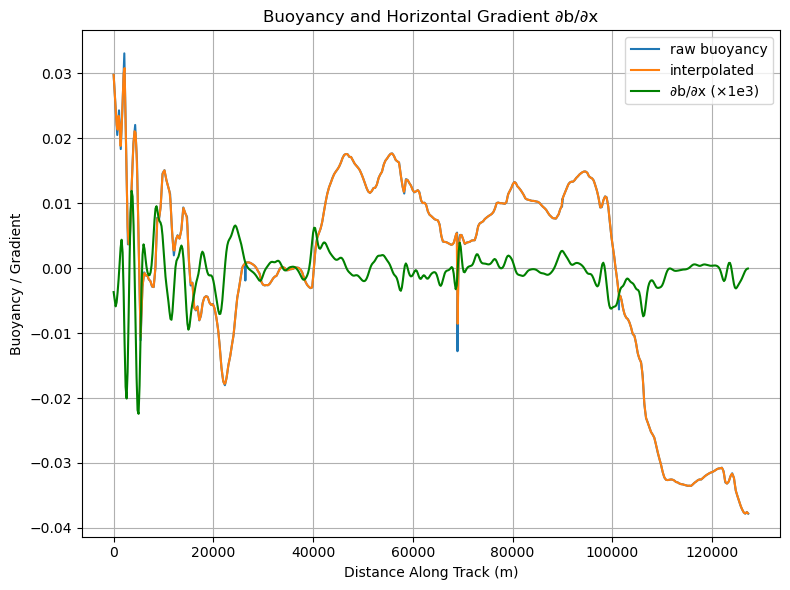

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(dist, b, label='raw buoyancy')               # original buoyancy (irregular)
plt.plot(d_reg, b_reg, label='interpolated')          # regular grid
plt.plot(d_reg, dbdx_reg * 1e3, label='∂b/∂x (×1e3)', color='green')

plt.xlabel('Distance Along Track (m)')
plt.ylabel('Buoyancy / Gradient')
plt.legend()
plt.title('Buoyancy and Horizontal Gradient ∂b/∂x')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
print("dbdx_reg shape:", dbdx_reg.shape)
print("d_reg shape:", d_reg.shape)


dbdx_reg shape: (637,)
d_reg shape: (637,)


In [10]:
# saving the regular grid in the dataframe

df_dbdx = pd.DataFrame({
    "distance_m": d_reg,
    "buoyancy": b_reg,
    "dbdx": dbdx_reg})


In [11]:
print(f"Total points: {len(df_all)}")
print(f"Within 2±0.5 m: {np.sum(mask)}")
print(f"Removed: {len(df_all) - np.sum(mask)}")


Total points: 468
Within 2±0.5 m: 468
Removed: 0


Open the weather data to compute the Ekman bouyancy flux (Dont mind the position data)

In [12]:
df_wind = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_weather.csv")
# df_pos = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_position.csv")

In [13]:
df_wind['ts'] = pd.to_datetime(df_wind['ts']).dt.round('1s')
# df_pos['ts'] = pd.to_datetime(df_pos['ts']).dt.round('1s')

# df = pd.merge(df_pos, df_wind, on='ts', how='inner')

In [14]:
df_wind = df_wind.rename(columns={'ts': 'Time'})
df_wind = df_wind.rename(columns={'longitude': 'Longitude'})
df_wind = df_wind.rename(columns={'latitude': 'Latitude'})

Compute windstress

In [15]:
# Get windstress

# ── 2.  vectorised air-density ρ_a(T, p, RH) ───────────────────────────
T   = df_wind['airtemp'].to_numpy(float)         # °C
P   = df_wind['airpressure'].to_numpy(float) * 100    # hPa → Pa
RH  = df_wind['humidity'].to_numpy(float) / 100     # %

Rd, Rv = 287.05, 461.5
es = 611.2 * np.exp((17.67 * T) / (T + 243.5))   # Pa (sat. vapour press.)
e  = RH * es                                     # Pa (actual vapour press.)
rho_air = (P - e) / (Rd * (T + 273.15)) + e / (Rv * (T + 273.15))

# ── 3.  wind-vector components (u, v) from speed + “from” direction ────
U     = df_wind['windspeed'].to_numpy(float)          # m s⁻¹
theta_wind = np.deg2rad(df_wind['winddir'].to_numpy(float))

u = -U * np.sin(theta_wind)      # eastward (+ = toward east)
v = -U * np.cos(theta_wind)      # northward (+ = toward north)

# ── 4.  constant drag coefficient & wind-stress components ─────────────
Cd   = 1.5e-3                                    # dimensionless
tau  = rho_air * Cd * U**2                       # magnitude  (N m⁻²)
tau_x = rho_air * Cd * U * u                     # eastward stress
tau_y = rho_air * Cd * U * v                     # northward stress

# store in DataFrame
df_wind['tau']   = tau
df_wind['tau_x'] = tau_x
df_wind['tau_y'] = tau_y
df_wind['theta_wind'] = theta_wind
df_wind['u_wind'] = u
df_wind['v_wind'] = v


# ── 5.  quick sanity print ─────────────────────────────────────────────
print(df_wind[['tau', 'tau_x', 'tau_y']].head())

        tau     tau_x     tau_y
0  0.021691 -0.004510 -0.021217
1  0.020434 -0.004597 -0.019910
2  0.018033  0.008466 -0.015922
3  0.011727 -0.001429 -0.011640
4  0.027085  0.001889 -0.027019


Sortera winddatan och ferrybox datan på tid för att kunna aligna dom

In [16]:
df_all['datetime'] = pd.to_datetime(df_all['Date'].astype(str) + ' ' + df_all['Time'].astype(str))
df_wind['datetime'] = pd.to_datetime(df_wind['Time'])

df_all = df_all.sort_values('datetime')
df_wind = df_wind.sort_values('datetime')  

In [17]:
# Add distance to df_clean (which corresponds to the buoyancy and positions)
df_clean['dist_m'] = dist


In [18]:
df_clean.shape

(468, 31)

In [19]:
wind_interp_cols = ['tau_x', 'tau_y', 'tau', 'theta_wind']

# Interpolate wind variables to df_clean['datetime'] first
df_wind = df_wind.set_index('Time')

for var in wind_interp_cols:
    interp_func = interp1d(df_wind.index.astype(np.int64), df_wind[var], bounds_error=False, fill_value=np.nan)
    df_clean[var] = interp_func(df_clean['datetime'].astype(np.int64))

# Now interpolate to regular distance grid
for var in wind_interp_cols:
    interp_func = interp1d(df_clean["dist_m"], df_clean[var], bounds_error=False, fill_value=np.nan)
    df_dbdx[var] = interp_func(d_reg)




Compute corilois and then EBF

In [20]:
omega = 7.2921 * 10**-5  # Earth's rotation rate in rad/s
theta = 57  # Latitude in degrees

# Convert to radians
theta_rad = np.deg2rad(theta)

# Compute Coriolis parameter
f = 2 * omega * np.sin(theta_rad)

print(f"Coriolis parameter at {theta}°: {f:.3e} s⁻¹")


Coriolis parameter at 57°: 1.223e-04 s⁻¹


In [21]:
# Constants
Cp = 4000 # J kg-1 K-1 # specific heat of water
# alpha = 10**-4
#alpha = 5.7
df_clean['alpha'] = gsw.alpha(df_clean['SA'], df_clean['CT'], df_clean['pressure'] / 100)
alpha = df_clean['alpha']
#alpha_const = 2*10**-4
g = 9.82
#tau_const = 0.02


# prepare the two source tables
bx   = df_clean[['datetime', 'buoy_grad', 'Longitude', 'Latitude']]      
tau  = df_clean[['datetime','tau']]  # 

# inner-join ⇒ keeps only timestamps present in **both** tables
combo = pd.merge(bx, tau, on='datetime', how='inner')
combo = pd.merge(combo, df_clean[['datetime', 'alpha']], on='datetime', how='left')

#combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / (f)) * ((Cp) / (alpha * g))
combo['Q_EBF'] = -((combo['buoy_grad'] * combo['tau']) / f) * (Cp / (alpha * g))


# get ADCP data to get the alongfront wind

In [22]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import pytz

# File path
file_path = r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\adcp_data_6_maj.txt' # Day 1

# Read and clean raw data
raw = pd.read_csv(file_path, sep="\t", skiprows=12, engine="python")
raw = raw.map(lambda x: str(x).replace(",", "."))  # replace comma decimals
raw = raw.iloc[3:-3].reset_index(drop=True)

# Convert numeric columns
numeric_cols = raw.columns.drop(['    "FLat"', '    "FLon"', '    "LLat"', '    "LLon"'])
raw[numeric_cols] = raw[numeric_cols].astype(float)

# Extract ADCP velocities
east = raw[[f"Eas{'.'+str(i) if i else ''}" for i in range(10)]].to_numpy()
north = raw[[f"Nor{'.'+str(i) if i else ''}" for i in range(10)]].to_numpy()

# Build datetime list
t = [dt.datetime(2000+int(y), int(m), int(d), int(HH), int(MM), int(SS))
     for y, m, d, HH, MM, SS in raw[['YR','MO','DA','HH','MM','SS']].to_numpy()]

# Timezone correction (from UTC+2 → UTC)
local_tz = pytz.timezone('Europe/Stockholm')
t_localized = [local_tz.localize(time) for time in t]
t_utc = [time.astimezone(pytz.utc).replace(tzinfo=None) for time in t_localized]

# Create DataArrays
depth = np.arange(8, 8+4*10, 4)
east_da = xr.DataArray(east, dims=["time", "depth"], coords={"time": t_utc, "depth": depth}, name="east_velocity")
north_da = xr.DataArray(north, dims=["time", "depth"], coords={"time": t_utc, "depth": depth}, name="north_velocity")

# Latitude & longitude
lat = raw['    "FLat"'].astype(float)
lon = raw['    "FLon"'].astype(float)

# Build xarray dataset
ds = xr.merge([east_da, north_da])
ds = ds.where(np.abs(ds) < 500)          # remove spikes
ds = ds / 1000                           # mm/s → m/s
ds = ds.assign_coords(lat=("time", lat), lon=("time", lon))

# Final: align time ranges with df_clean/df_wind
start_time = pd.to_datetime(ds.time.values[0])
end_time = pd.to_datetime(ds.time.values[-1])
df_wind = df_wind[(df_wind['datetime'] >= start_time) & (df_wind['datetime'] <= end_time)].copy()
df_clean = df_clean[(df_clean['datetime'] >= start_time) & (df_clean['datetime'] <= end_time)].copy()

df_wind = df_wind.sort_values('datetime')
df_clean = df_clean.sort_values('datetime')


In [23]:
print("ADCP time range:", ds.time.values.min(), "→", ds.time.values.max())
print("Wind time range:", df_wind['datetime'].min(), "→", df_wind['datetime'].max())


ADCP time range: 2025-05-06T07:57:45.000000000 → 2025-05-06T14:47:44.000000000
Wind time range: 2025-05-06 07:58:00 → 2025-05-06 14:47:00


In [36]:
from datetime import timedelta

# Print first ADCP timestamp
print("ADCP UTC start:", ds.time.values[0])
print("ADCP local time:", pd.to_datetime(ds.time.values[0]) + timedelta(hours=2))

# Print first FerryBox time
print("FerryBox start (UTC):", df_clean['datetime'].min())



ADCP UTC start: 2025-05-06T07:57:45.000000000
ADCP local time: 2025-05-06 09:57:45
FerryBox start (UTC): 2025-05-06 07:58:00


In [37]:
u_avg = ds["east_velocity"].mean(dim="depth")
v_avg = ds["north_velocity"].mean(dim="depth")

#Convert (u, v) → direction angle (radians or degrees):
theta_current_rad = np.arctan2(v_avg, u_avg)  # radians
theta_current_deg = np.degrees(theta_current_rad) % 360  # convert to 0–360°
# This gives a time series of current direction.

In [38]:
theta_wind_series = df_wind.set_index('datetime')['theta_wind']

# Make sure datetime is set
tau_series = df_wind.set_index('datetime')['tau']

# Interpolate to ADCP timestamps
tau_interp = np.interp(
    ds.time.values.astype(np.int64),   # ADCP time
    tau_series.index.values.astype(np.int64),  # wind time
    tau_series.values
)


In [39]:
# Convert timestamps to nanoseconds for numerical interpolation
adcp_time_ns = ds.time.values.astype(np.int64)
wind_time_ns = theta_wind_series.index.values.astype(np.int64)

# Interpolation
theta_wind_interp = np.interp(adcp_time_ns, wind_time_ns, theta_wind_series.values)

In [40]:
theta_wind_deg = np.degrees(theta_wind_interp) % 360  # ensure in degrees
delta_theta_deg = (theta_wind_deg - theta_current_deg + 360) % 360  # angle difference in degrees
delta_theta_rad = np.radians(delta_theta_deg)  # convert to radians for trigonometry

# Project wind stress onto and across the current direction
tau_cross = tau_interp * np.sin(delta_theta_rad)
tau_along = tau_interp * np.cos(delta_theta_rad)




In [41]:
print("tau_along min/max:", np.nanmin(tau_along), np.nanmax(tau_along))
print("delta_theta_deg min/max:", np.nanmin(delta_theta_deg), np.nanmax(delta_theta_deg))
print("theta_wind_deg min/max:", np.nanmin(theta_wind_deg), np.nanmax(theta_wind_deg))
print("theta_current_deg min/max:", np.nanmin(theta_current_deg), np.nanmax(theta_current_deg))


tau_along min/max: -0.3777010336732902 0.24843230336680888
delta_theta_deg min/max: 3.2389078122726005 357.9691744812184
theta_wind_deg min/max: 0.0 351.4666666666667
theta_current_deg min/max: 9.015057448546546 347.81634341401264


In [42]:
print(len(df_clean["dist_m"]))
print(len(tau_along))
print


410
83


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [43]:
adcp_time = ds.time.values  # or ds["time"].values


# First: find the matching distances
dist_adcp = np.interp(adcp_time.astype(np.int64), df_clean["datetime"].astype(np.int64), df_clean["dist_m"])

# Then: interpolate tau_along from ADCP distances to regular grid
tau_along_reg = np.interp(d_reg, dist_adcp, tau_along)

# Same for alpha
alpha_adcp = np.interp(adcp_time.astype(np.int64), df_clean["datetime"].astype(np.int64), df_clean["alpha"])
alpha_reg = np.interp(d_reg, dist_adcp, alpha_adcp)



In [44]:
Q_EBF = - (dbdx_reg * tau_along_reg) * (Cp / (alpha_reg * g * f))

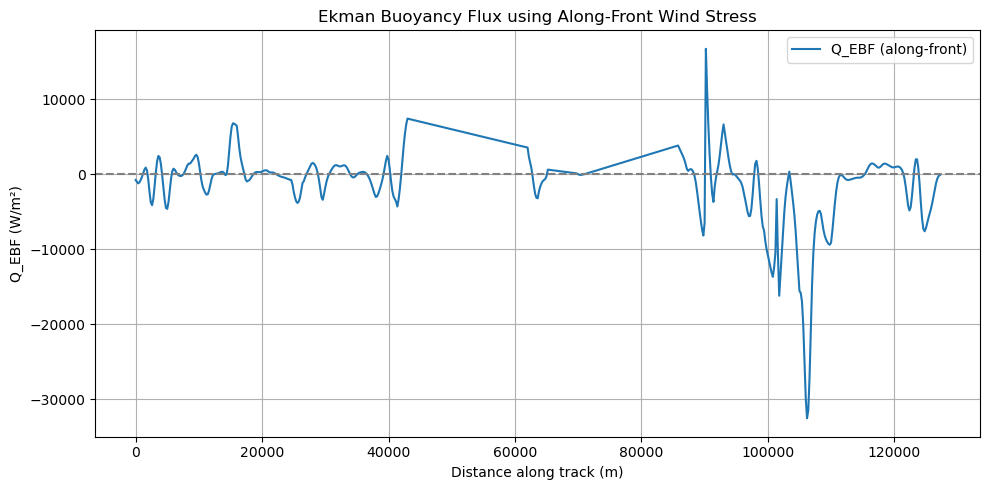

In [45]:
# # Clean up invalid points (optional but recommended)

mask = (~np.isnan(Q_EBF)) & (~np.isnan(dbdx_reg)) & (~np.isnan(tau_along_reg)) & (~np.isnan(alpha_reg)) & (alpha_reg > 1e-6)

df_Q = pd.DataFrame({
    "distance_m": d_reg[mask],
    "tau_along": tau_along_reg[mask],
    "alpha": alpha_reg[mask],
    "dbdx": dbdx_reg[mask],
    "Q_EBF": Q_EBF[mask]
})


plt.figure(figsize=(10, 5))
plt.plot(df_Q["distance_m"], df_Q["Q_EBF"], label="Q_EBF (along-front)")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Distance along track (m)")
plt.ylabel("Q_EBF (W/m²)")
plt.title("Ekman Buoyancy Flux using Along-Front Wind Stress")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



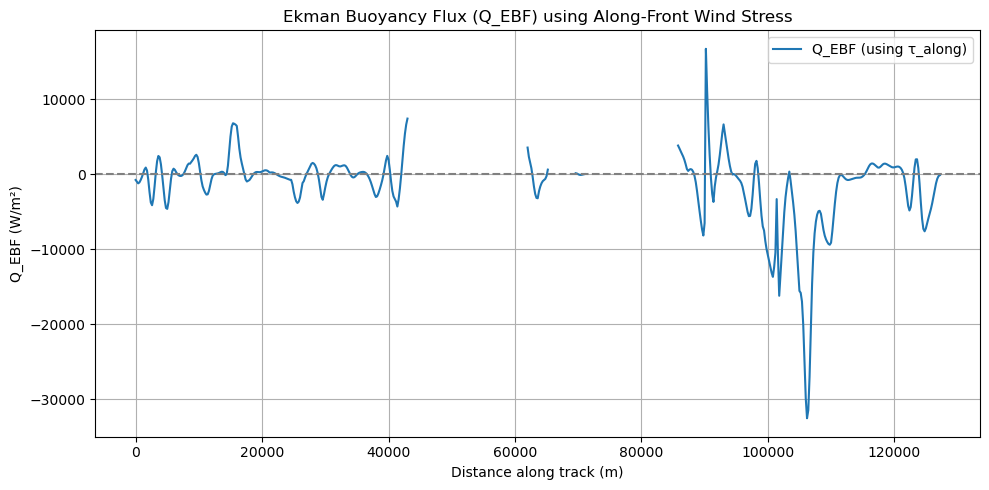

In [46]:
# If not cleaning up invalid points

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(d_reg, Q_EBF, label='Q_EBF (using τ_along)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Distance along track (m)")
plt.ylabel("Q_EBF (W/m²)")
plt.title("Ekman Buoyancy Flux (Q_EBF) using Along-Front Wind Stress")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

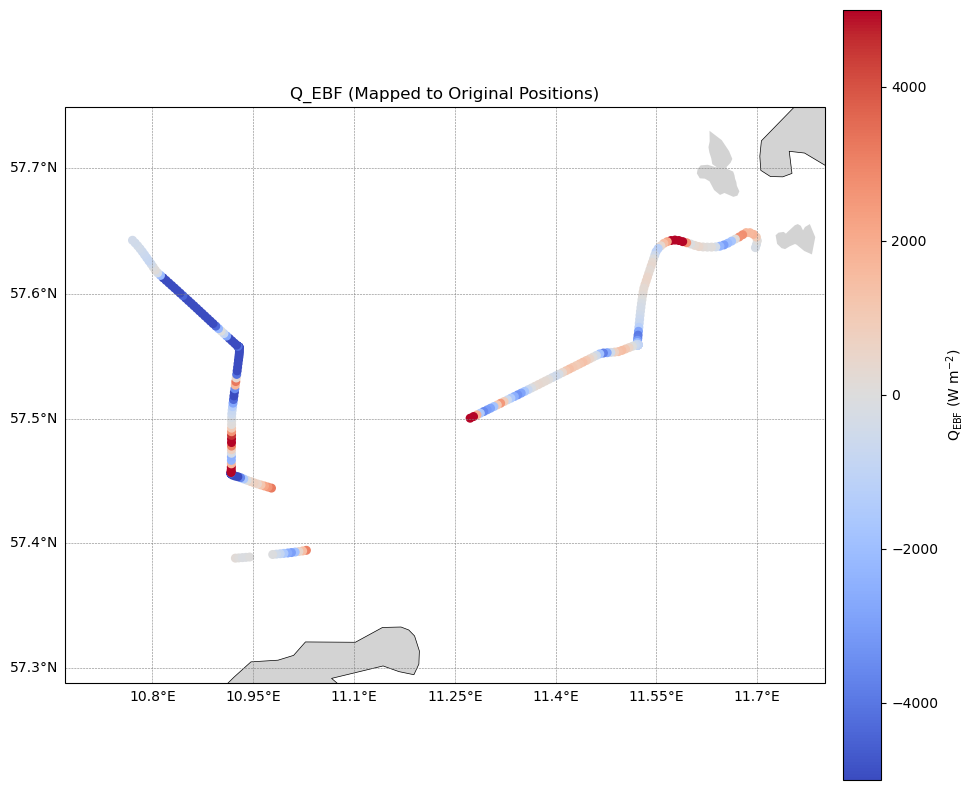

In [43]:
# Interpolate Q_EBF back to df_clean["dist_m"] (same as Longitude/Latitude)
Q_EBF_interp = np.interp(df_clean["dist_m"], d_reg, Q_EBF, left=np.nan, right=np.nan)

# Then plot it
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Define extent
lat_min, lat_max = df_clean['Latitude'].min(), df_clean['Latitude'].max()
lon_min, lon_max = df_clean['Longitude'].min(), df_clean['Longitude'].max()
extent = [lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1]
ax.set_extent(extent, crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", linestyle="--")
gl.top_labels = False
gl.right_labels = False

# Use interpolated Q_EBF
sc = ax.scatter(df_clean['Longitude'], df_clean['Latitude'],
                c=Q_EBF_interp, cmap='coolwarm', s=30,
                transform=ccrs.PlateCarree(), vmin=-5000, vmax=5000)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Q$_{\\mathrm{EBF}}$ (W m$^{-2}$)')

ax.set_title('Q_EBF (Mapped to Original Positions)')
plt.tight_layout()
plt.show()


In [113]:
print(np.nanmin(alpha_reg), np.nanmax(alpha_reg))



0.00014164932777825626 0.00016299528629641955


In [101]:
df_Q

,distance_m,tau_along,alpha,dbdx,Q_EBF
0,0.0,0.158607,0.000145,-4.482815e-06,16364.461209
1,150.0,0.158607,0.000145,-6.007010e-06,21928.518207
2,300.0,0.158607,0.000145,-7.930759e-06,28951.138525
3,450.0,0.158607,0.000145,-7.670817e-06,28002.223608
4,600.0,0.158607,0.000145,-5.817587e-06,21237.030237
...,...,...,...,...,...
594,126600.0,0.252055,0.000163,-3.892543e-07,2004.603841
595,126750.0,0.252055,0.000163,-1.616479e-07,832.463227
596,126900.0,0.252055,0.000163,-4.402494e-08,226.722110
597,127050.0,0.252055,0.000163,-7.386820e-09,38.041062


In [102]:
import pandas as pd
print(pd.Series(Q_EBF).describe())


count       599.000000
mean       3354.964967
std       15576.566165
min      -59454.009295
25%       -2155.108540
50%         536.094292
75%        7043.458340
max      105398.922790
dtype: float64


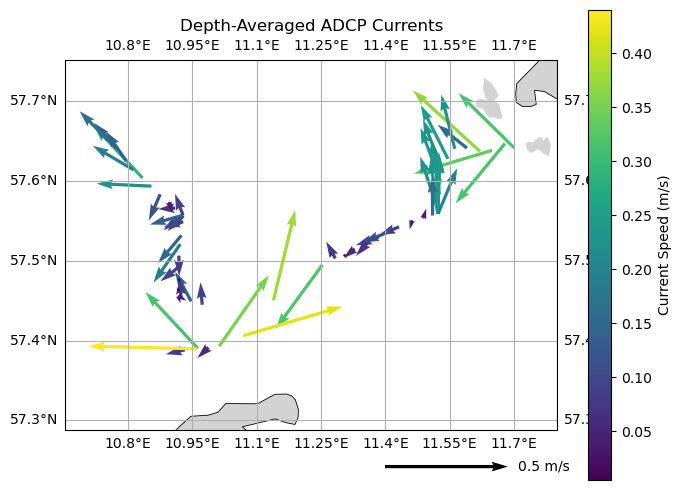

In [103]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Depth-averaged current
u_avg = ds["east_velocity"].mean(dim="depth")
v_avg = ds["north_velocity"].mean(dim="depth")

# Extract positions and convert to numpy
lon = ds["lon"].values
lat = ds["lat"].values
u = u_avg.values
v = v_avg.values

# Optional: thin the data for readability
skip = 1  # plot every 5th arrow
lon = lon[::skip]
lat = lat[::skip]
u = u[::skip]
v = v[::skip]

# Plot
plt.figure(figsize=(7, 5))
ax = plt.axes(projection=ccrs.Mercator())

# Set extent with padding
buffer = 0.1
ax.set_extent([
    np.nanmin(lon) - buffer, np.nanmax(lon) + buffer,
    np.nanmin(lat) - buffer, np.nanmax(lat) + buffer
], crs=ccrs.PlateCarree())

# Base map
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.gridlines(draw_labels=True)

speed = np.sqrt(u**2 + v**2)
# Plot quiver
q = ax.quiver(
    lon, lat, u, v, speed, cmap='viridis',
    transform=ccrs.PlateCarree(), scale=2
)
ax.quiverkey(q, 0.9, -0.1, 0.5, '0.5 m/s', labelpos='E')


plt.colorbar(q, ax=ax, label='Current Speed (m/s)')
plt.title("Depth-Averaged ADCP Currents")
plt.tight_layout()
plt.show()


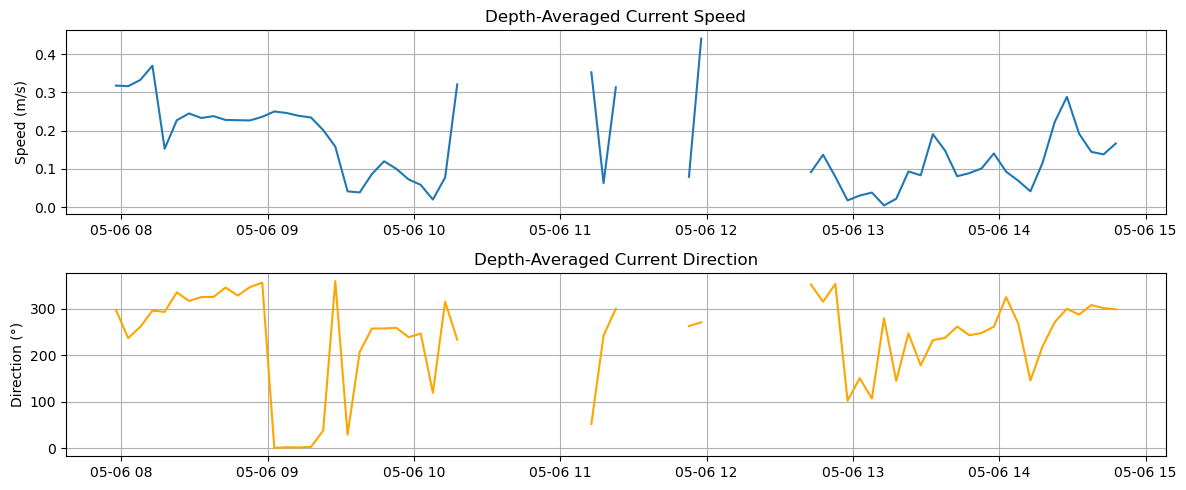

In [104]:
# Assuming you have u_avg and v_avg already:
u_avg = ds["east_velocity"].mean(dim="depth")
v_avg = ds["north_velocity"].mean(dim="depth")

speed = np.sqrt(u_avg**2 + v_avg**2)
theta_current = np.degrees(np.arctan2(u_avg, v_avg)) % 360

plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(ds["time"], speed, label="Speed")
plt.ylabel("Speed (m/s)")
plt.title("Depth-Averaged Current Speed")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(ds["time"], theta_current, label="Direction", color="orange")
plt.ylabel("Direction (°)")
plt.title("Depth-Averaged Current Direction")
plt.grid(True)

plt.tight_layout()
plt.show()


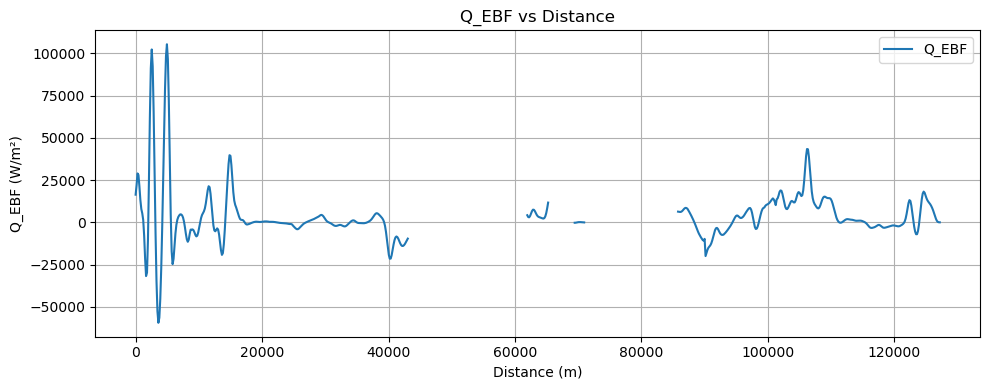

In [105]:
plt.figure(figsize=(10, 4))
plt.plot(d_reg, Q_EBF, label="Q_EBF")
plt.xlabel("Distance (m)")
plt.ylabel("Q_EBF (W/m²)")
plt.title("Q_EBF vs Distance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [106]:
# Check first and last rows of ADCP data

# Compute u, v
u_avg = ds["east_velocity"].mean(dim="depth")
v_avg = ds["north_velocity"].mean(dim="depth")

# Compute speed and direction
speed = np.sqrt(u_avg**2 + v_avg**2)
theta = (np.degrees(np.arctan2(u_avg, v_avg)) + 360) % 360

# Combine and print last 10
for i in range(-10, 0):
    print(f"{ds['time'].values[i]} → speed: {speed.values[i]:.3f} m/s, direction: {theta.values[i]:.1f}°")



# Combine and print last 10
for i in range(0, 10):
    print(f"{ds['time'].values[i]} → speed: {speed.values[i]:.3f} m/s, direction: {theta.values[i]:.1f}°")


2025-05-06T14:02:47.000000000 → speed: 0.093 m/s, direction: 324.9°
2025-05-06T14:07:45.000000000 → speed: 0.070 m/s, direction: 268.4°
2025-05-06T14:12:45.000000000 → speed: 0.042 m/s, direction: 145.7°
2025-05-06T14:17:43.000000000 → speed: 0.116 m/s, direction: 219.0°
2025-05-06T14:22:45.000000000 → speed: 0.223 m/s, direction: 271.4°
2025-05-06T14:27:43.000000000 → speed: 0.288 m/s, direction: 299.9°
2025-05-06T14:32:43.000000000 → speed: 0.192 m/s, direction: 287.6°
2025-05-06T14:37:44.000000000 → speed: 0.145 m/s, direction: 308.0°
2025-05-06T14:42:46.000000000 → speed: 0.138 m/s, direction: 301.4°
2025-05-06T14:47:44.000000000 → speed: 0.166 m/s, direction: 298.7°
2025-05-06T07:57:45.000000000 → speed: 0.318 m/s, direction: 297.8°
2025-05-06T08:02:46.000000000 → speed: 0.316 m/s, direction: 237.0°
2025-05-06T08:07:44.000000000 → speed: 0.332 m/s, direction: 260.9°
2025-05-06T08:12:44.000000000 → speed: 0.369 m/s, direction: 295.9°
2025-05-06T08:17:45.000000000 → speed: 0.153 m/s

In [107]:
df_wind

,airtemp,humidity,airpressure,windspeed,winddir,tau,tau_x,tau_y,theta_wind,u_wind,v_wind,datetime
Time,,,,,,,,,,,,
2025-05-06 07:58:00,9.1,42,1014.4,9.2,59,0.158671,-0.136008,-0.081722,1.029744,-7.885939,-4.738350,2025-05-06 07:58:00
2025-05-06 07:59:00,9.0,40,1014.6,8.6,68,0.138740,-0.128638,-0.051973,1.186824,-7.973781,-3.221617,2025-05-06 07:59:00
2025-05-06 08:00:00,9.0,41,1014.7,6.0,100,0.067535,-0.066509,0.011727,1.745329,-5.908847,1.041889,2025-05-06 08:00:00
2025-05-06 08:01:00,9.1,42,1015.0,1.2,153,0.002701,-0.001226,0.002407,2.670354,-0.544789,1.069208,2025-05-06 08:01:00
2025-05-06 08:02:00,9.1,43,1014.9,1.7,109,0.005420,-0.005125,0.001765,1.902409,-1.607382,0.553466,2025-05-06 08:02:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-06 14:43:00,9.5,52,1016.6,10.5,33,0.206736,-0.112596,-0.173383,0.575959,-5.718710,-8.806041,2025-05-06 14:43:00
2025-05-06 14:44:00,9.6,52,1016.7,10.5,32,0.206680,-0.109524,-0.175274,0.558505,-5.564152,-8.904505,2025-05-06 14:44:00
2025-05-06 14:45:00,9.6,53,1016.7,11.2,35,0.235145,-0.134874,-0.192620,0.610865,-6.424056,-9.174503,2025-05-06 14:45:00


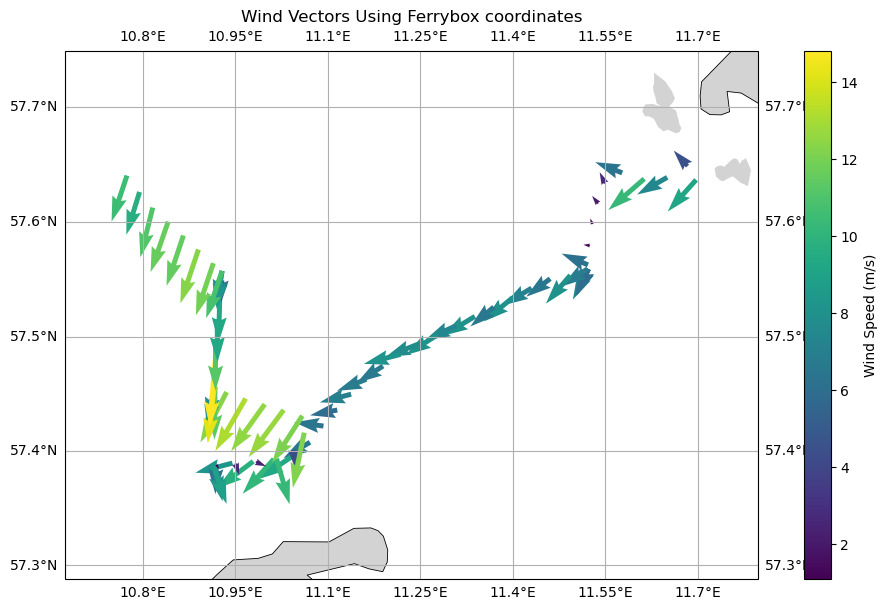

In [130]:
# Interpolera vinddatan till Ferrybox datan

from scipy.interpolate import interp1d

from scipy.interpolate import interp1d

# Interpolation functions using the existing DatetimeIndex
interp_u = interp1d(df_wind.index.astype(np.int64), df_wind['u_wind'], bounds_error=False, fill_value=np.nan)
interp_v = interp1d(df_wind.index.astype(np.int64), df_wind['v_wind'], bounds_error=False, fill_value=np.nan)

# Apply interpolation to df_clean's datetime values
df_clean['u_wind'] = interp_u(df_clean['datetime'].astype(np.int64))
df_clean['v_wind'] = interp_v(df_clean['datetime'].astype(np.int64))




import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Thin data to improve readability
skip = 6
lon = df_clean['Longitude'].values[::skip]
lat = df_clean['Latitude'].values[::skip]
u = df_clean['u_wind'].values[::skip]
v = df_clean['v_wind'].values[::skip]
speed = np.sqrt(u**2 + v**2)

# Plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mercator())

buffer = 0.1
ax.set_extent([
    np.nanmin(lon) - buffer, np.nanmax(lon) + buffer,
    np.nanmin(lat) - buffer, np.nanmax(lat) + buffer
], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.gridlines(draw_labels=True)

q = ax.quiver(lon, lat, u, v, speed, cmap='viridis',
              scale=150, transform=ccrs.PlateCarree())
ax.quiverkey(q, 0.9, -0.1, 5, '5 m/s', labelpos='E')

plt.colorbar(q, ax=ax, label='Wind Speed (m/s)')
plt.title("Wind Vectors Using Ferrybox coordinates")
plt.tight_layout()
plt.show()



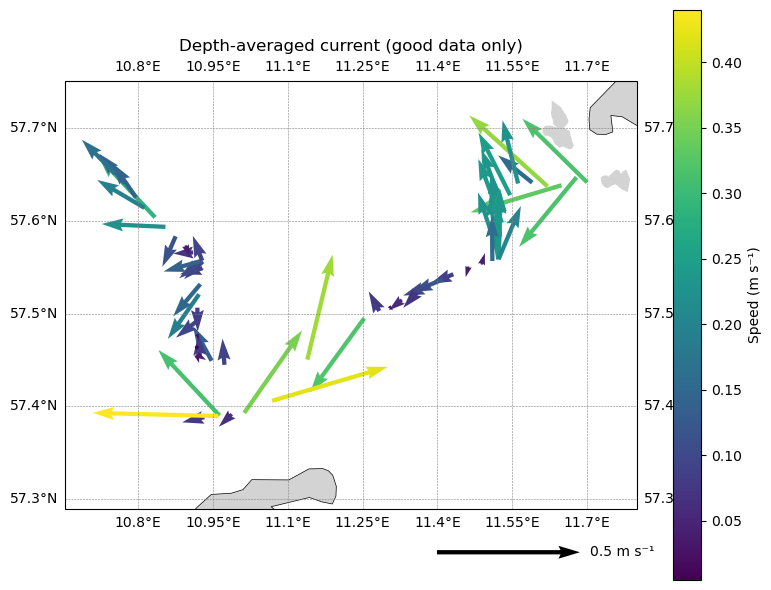

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature

# ------------------------------------------------------------------
# 1.  Build vectors (depth-averaged OR surface-bin, you choose)
# ------------------------------------------------------------------
lon  = ds["lon"].values
lat  = ds["lat"].values
u    = u_avg.values           # depth-averaged east velocity  (m s-1)
v    = v_avg.values           # depth-averaged north velocity (m s-1)

# ------------------------------------------------------------------
# 2.  Mask out bad rows  -------------------------------------------
#     – keep only points where *both* components are finite
#     – optionally also discard speeds below some noise level
# ------------------------------------------------------------------
mask  = np.isfinite(u) & np.isfinite(v)        # + any other criteria
lon   = lon[mask]
lat   = lat[mask]
u     = u[mask]
v     = v[mask]

# thin for readability
skip  = 1
lon, lat, u, v = lon[::skip], lat[::skip], u[::skip], v[::skip]

# speed only for colouring
speed = np.hypot(u, v)

# ------------------------------------------------------------------
# 3.  Plot clean quiver map ----------------------------------------
# ------------------------------------------------------------------
fig = plt.figure(figsize=(8, 6))
ax  = plt.axes(projection=ccrs.Mercator())

pad = 0.1
ax.set_extent([lon.min()-pad, lon.max()+pad,
               lat.min()-pad, lat.max()+pad],
              crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.4,
             linestyle='--', color='gray')

q = ax.quiver(lon, lat, u, v, speed, cmap='viridis',
              scale=2, transform=ccrs.PlateCarree())
ax.quiverkey(q, 0.9, -0.1, 0.5, '0.5 m s⁻¹', labelpos='E')
plt.colorbar(q, ax=ax, label='Speed (m s⁻¹)')
ax.set_title('Depth-averaged current (good data only)')
plt.tight_layout(); plt.show()
